In [35]:
import numpy as np
from numba import jit, prange, njit, vectorize
import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time
#import scripts.tools as tools
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate as itp
import pandas as pd 
from scipy.optimize import curve_fit
from scipy.signal import argrelmax
#import qcodes
#import scripts.tvregdiff as tvregdiff


# Settings

In [47]:
R=0.75 #cm
H=0.2
N=500
M=200
position_of_electrons=100 

hr=R/N
hz=H/M

e=4.80324e-10
mass=9.1e-28

N_Vib=np.round(0.4/hr)
N_Vmb=np.round(0.57/hr)
N_Vob = np.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)
# folder = "../density_profile/GreenFunction/"
# eps=1e-10
# GreenFuncName = 'Green_njit_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(int(np.log10(eps))) + '.npy'
# print(folder+GreenFuncName)


folder = "GreenFunctions/good_versions//"
eps=1e-10
GreenFuncName = 'Green_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '.npy'

G = np.load(folder+GreenFuncName)

dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))

for n in range(0, N):
    for i in range(0, N):
        # ----------- Green function difference along the charge pool ----------- #
        dGr[n,i] = -4 * np.pi * e * (G[position_of_electrons,i+1,n] - G[position_of_electrons,i,n])
        # ----------- Green function difference across the cell's top ------------# 
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz)


# $V_{ib}$ sweep

## Load the density functions

<>:73: SyntaxWarning: invalid escape sequence '\e'
<>:73: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_54116\3780347160.py:73: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f'Density profiles for different Vmb potentials ($\epsilon={eps} ,N={N}, M={M}$)')


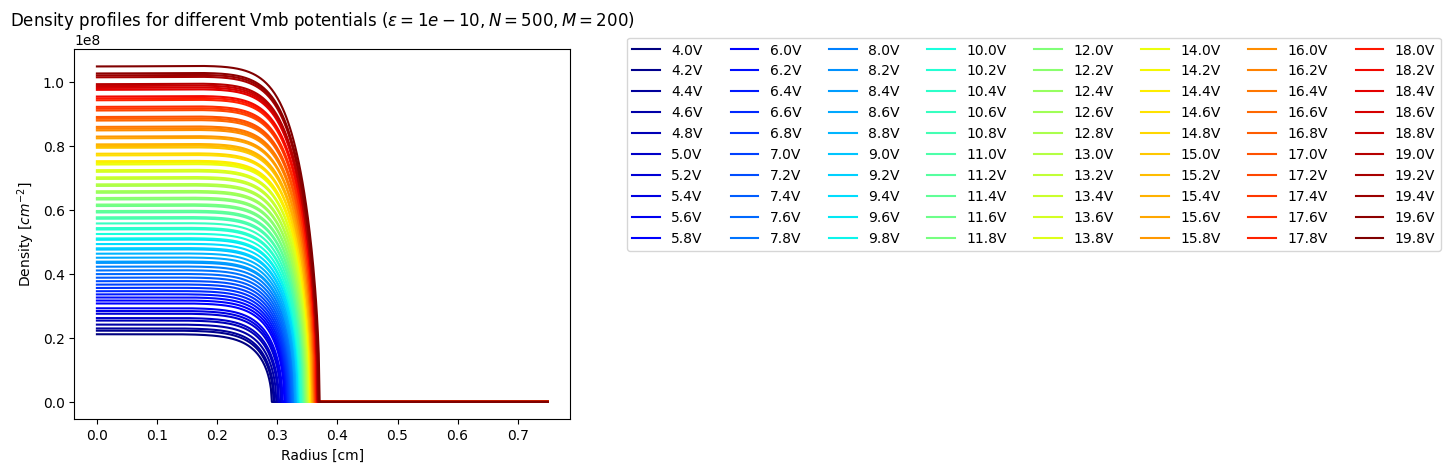

In [65]:
# choose the same parameters as for density calculation 
# so that the loaded files do exist
# pay attention to the last voltage 
Vmb=-15
Vob=-15


startVib = 4
endVib = 20
stepVib = 0.2
# Calculate the number of files (steps) to determine the colormap size
v_loop = np.arange(startVib, endVib, stepVib)
numFiles = len(v_loop)
 
# Generate a colormap
colormap = plt.jet()

# Define the base path to the files
# if you downloaded the folder Vmbsweep from the drive: https://drive.google.com/drive/folders/1lC1xuzMQvBS7sev4N5r9cZi6F-KcE2N-
# and that you put it in one of your folders on your desktop, the folder path should look like this:
# folder = "../density_profile/VmbSweep/Vib10V_Vobm32V/fixed_electron_number_density/"
folder =f"C:/Users/riken/Desktop/Folder_Thomas/Plasmon/DensityFiles/Vib_sweep_good/-15V/"

column_names = ["rcm", "densitycm2"]
column_types = {"rcm": "float64", "densitycm2": "float64"}


# creates a label for each plotted line
legLabels = [None] * int(numFiles)

# Create a list to store the data for each file
DataStruct = [{} for _ in range(numFiles)]

A = np.zeros(N+1)
rdash = np.zeros(N+1)

A[0] = np.pi * np.power(hr/2, 2)
A[N] = np.pi * (N + 1 - 5/4) * np.power(hr, 2)
A[1:N] = 2 * np.pi * (np.arange(2, N+1) - 1) * np.power(hr, 2)

rdash[0:N+1] = (np.arange(0, N+1) + 1/2) * hr

# Loop through each file
colors = plt.cm.jet(np.linspace(0,1,len(v_loop)))
fileIndex = 0 # Initialize a counter for the file index
for v in v_loop:
    # Generate the filename
    Vib_str = f"{v:.1f}".replace(".", "p")
    
    if np.abs(v) < 0:
        Vib_str = f"{-v:.1f}".replace(".", "p")

    filename = f"saturated_density_Vib{Vib_str}_Vob{Vob}_Vmb{Vmb}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    file = np.load(folder+filename, allow_pickle=True)
    
    DataStruct[fileIndex] = {
        'r': file[0],
        'density': file[1],
        'Vib': v,
        'N_electrons': np.sum(A*file[1])
    }  

    # Plot density vs r with the color corresponding to the voltage
    plt.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])

    # Generate label for this line and store it
    legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vib']:.1f}V"
    fileIndex += 1 # Increment the file index


plt.xlabel('Radius [cm]')
plt.ylabel('Density $[cm^{-2}]$')
plt.title(f'Density profiles for different Vmb potentials ($\epsilon={eps} ,N={N}, M={M}$)')
plt.legend(legLabels, ncol=8, bbox_to_anchor=(1.1, 1.05))

plt.show()

# check if the density plots have the same profile as in the ones plotted in DensityProfile_Vmb_sweep.ipynb

## Define function to calculate $\tilde \Phi$ the potential created by the AC voltage

In [66]:
iRange = np.arange(2, N+1)
# function to efficiently copy a 2D array
@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = np.full((M+1,N+1),-1/300)
fitil = np.full((M+1,N+1),-1/300)
aStart = np.zeros((M-1, N+1))
a = np.zeros((M-1, N+1))

# function to calculate the potential created by the AC voltage
def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    np.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    
    
    count = 0
    errHere = 1e-10
    print(count)
    np.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        np.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)

        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(np.abs(fitil[1:M, 0:N+1] - a))

    return fitil
    

## Calculate $\tilde \Phi$ created by the AC voltage

In [67]:
Vib_AC=0/300
Vmb_AC=0/300
Vob_AC=0/300
# only 1 V is applied to the top inner electrode
# all the other electrodes are set to 0 (they only participate in the DC potential)
Vit_AC = 1/300
Vmt_AC=0/300
Vot_AC=0/300

Vr=0

# calculate the potential created by the AC voltage
phitil = fitilSOLUT(R,H,N,M,Vib_AC,Vmb_AC,Vob_AC,N_Vib,N_Vmb,Vit_AC,Vmt_AC,Vot_AC,N_Vit,N_Vmt,N_Vot, N_Vob,Vr)


Eztil = np.zeros(N+1)

Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N)

0
2.3196415137533358e-07
9.842301381042008e-08
4.1640159470024765e-08
1.752132549812102e-08
7.349699745074628e-09
3.0786157666131547e-09
1.2884192443409631e-09
5.386847313701426e-10
2.2494479564628966e-10


## Calculate the fields and the total number of electrons

Vib with the maximum saturated electron number: 19.800000000000015


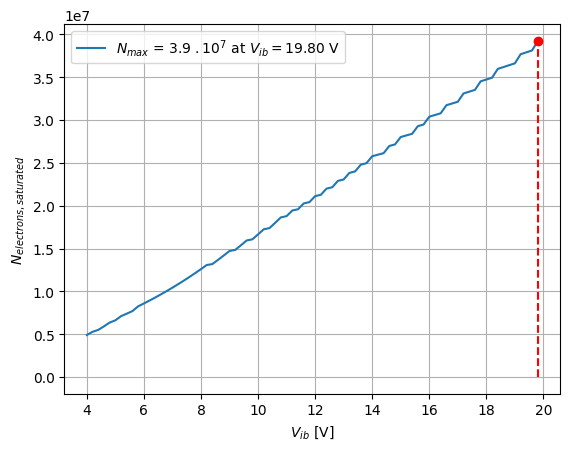

In [68]:
#-----------z component of the electric field (CGS) at the position of the electron layer (Eztil) and of the top electrode------------------#
for i in range(0, N+1):
    Eztil[i] = (phitil[position_of_electrons-1,i]-phitil[position_of_electrons,i])/hz
    Phitil[i] = phitil[position_of_electrons,i]
    

# --------- homogen. electric r-field at the el. layer (CGS) ------------ #
for i in range(0, N):
    Ertil[i] = (phitil[position_of_electrons,i]-phitil[position_of_electrons,i+1])/hr
    EztilTOP[i] = (phitil[M-1,i]-phitil[M,i])/hz

voltage = [struct['Vib'] for struct in DataStruct]
N_electrons_list = [struct['N_electrons'] for struct in DataStruct]
N_electrons_list = np.array(N_electrons_list)

# Find the maximum number of electrons (useful only if you loaded staturated density profiles)
idx = np.argmax(N_electrons_list)
v_max = voltage[idx]
n_max = N_electrons_list[idx]
print('Vib with the maximum saturated electron number:', v_max)

# Plot
# if you initially uploaded fixed N density profiles, the plot should be a horitzontal line with very small relative fluctuations
plt.plot(voltage, N_electrons_list, label=fr"$N_{{max}}$ = {(n_max*1e-7):.1f} $.10^7$ at $V_{{ib}} = {v_max:.2f}$ V")
plt.vlines(v_max, 0, n_max, color='red', linestyle='--', label='_nolegend_') 
plt.plot(v_max, n_max, 'ro')  

plt.xlabel('$V_{ib}$ [V]')
plt.ylabel('$N_{electrons, saturated}$')
plt.legend()
plt.grid(True)



## Calculate the plasmon frequencies and the impedance

In [69]:
# choose the RF frequency range for the impedance calculation
omega_vector = 2 * np.pi * np.linspace(120*1e6, 122*1e6, 401)

In [70]:
print(len(omega_vector))
fileIndex = 0

# choose tau which determines the scaterring rate of the electrons
tau = 3.85363e-8

# initialization
I_Vec = np.zeros(len(omega_vector), dtype = "complex")
I_Vec_start = np.zeros(len(omega_vector), dtype = "complex")

fileIndex = 0
deltafunc = np.eye(N+1,N+1)

E = np.zeros((N, N), dtype = "complex")
ETest = np.zeros((N, N), dtype = "complex")
D = np.zeros((N, N), dtype = "complex")
F = np.zeros((N, N), dtype = "complex")
H = np.zeros((N, N), dtype = "complex")

EStart = np.zeros((N, N), dtype = "complex")
DStart = np.zeros((N, N), dtype = "complex")

sigma = np.zeros(N, dtype = "complex")
b = np.zeros(N, dtype = "complex")

density_AC = np.zeros(N, dtype = "complex")

test1 = np.zeros((N, N), dtype = "complex")
test2 = np.zeros((N, N), dtype = "complex")

# Loop over each voltage
for v in v_loop:
    print(str((len(v_loop) - fileIndex))+ 'Iterations left')
    
    # ------- Find radius_of_electron_pool  -------- #
    density=np.array(DataStruct[fileIndex]["density"])

    # hr * K = radius_of_electron_pool
    # with the notations of the calculations, K=m+1
    K = np.amin((np.nonzero(np.array(density) == 0))) 
    
    np.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
    np.copyto(D[0:K, 0:K], DStart[0:K, 0:K])
    
    # -------- Calculate D (see Sec. V-B of the calculations that can be found here: the file Calculation_details.pdf at https://drive.google.com/drive/folders/1lC1xuzMQvBS7sev4N5r9cZi6F-KcE2N- )----------- #
    D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]
        

    # -------- Calculate E (see Sec. V-B of the calculations) ----------- #
    # Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 
    E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
    for j in range(0, K):
        E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

    np.copyto(I_Vec, I_Vec_start)
    for omega_pt in range(0, len(omega_vector)):

        omega = omega_vector[omega_pt]

        # -------- Calculate sigma, the conductivity----------- #
        sigma[0:K] = np.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate F----------- #
        F=np.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate b----------- #
        b[0] = rdash[0] * sigma[0] * Ertil[0]
        b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
        b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]
        
        # -------- Calculate H----------- #
        H[0:K,0:K] = -1j * (omega * e/(2*np.pi))*D[0:K,0:K]+F[0:K,0:K]
        
        #----------Calculate the densities ie the \delta n (cf calculations) ----------- #
        density_AC[0:K] = np.dot((b[:K]),np.linalg.inv((H[:K,:K])))

        # ------------------ use conservation of charge --------------------- #
        density_AC[K] = 0
        density_AC[K] -= np.sum(A[0:K] * (density_AC[0:K])/A[K])
        # ------------------ out of pool --------------------- #
        density_AC[K+1:N] = 0


        EzTop =-1 * np.dot(density_AC, dGzTOP)


        Q_AC=-np.sum(A[0:int(N_Vib)+1]*EzTop[0:int(N_Vib)+1]/(4*np.pi))
        # ------------------ calculate the impedance for a given Vmb and a given RF frequency--------------------- #
        I_Vec[omega_pt] = -1j * omega * Q_AC



    diagM, V = np.linalg.eig(2*np.pi*e/mass*np.dot(E[0:K, 0:K], np.linalg.inv(D[0:K, 0:K])))



    ind = np.argsort(diagM)
    d = np.sort(diagM)

    # choose the plasmons you want to store the frequencies of
    # you need : num_plasmons_to_store = len(plasmon_labels)
    plasmon_labels = ["First"]
    #print(plasmon_labels)
    # change here the number of plasmons
    num_plasmons_to_store = 1

    
    # if you want to start by storing let's say second plasmon, change the range of the loop as well as the plasmon layers
    for i in range(num_plasmons_to_store):
        label = plasmon_labels[i] + "Plasmon"
        #print(label)
        DataStruct[fileIndex][label] = np.sqrt(np.real(d[i])) / (2 * np.pi * 1e6)
    DataStruct[fileIndex]['Impedance'] = np.copy(I_Vec)

    fileIndex += 1 # Increment the file   



401
80Iterations left
79Iterations left
78Iterations left
77Iterations left
76Iterations left
75Iterations left
74Iterations left
73Iterations left
72Iterations left
71Iterations left
70Iterations left
69Iterations left
68Iterations left
67Iterations left
66Iterations left
65Iterations left
64Iterations left
63Iterations left
62Iterations left
61Iterations left
60Iterations left
59Iterations left
58Iterations left
57Iterations left
56Iterations left
55Iterations left
54Iterations left
53Iterations left
52Iterations left
51Iterations left
50Iterations left
49Iterations left
48Iterations left
47Iterations left
46Iterations left
45Iterations left
44Iterations left
43Iterations left
42Iterations left
41Iterations left
40Iterations left
39Iterations left
38Iterations left
37Iterations left
36Iterations left
35Iterations left
34Iterations left
33Iterations left
32Iterations left
31Iterations left
30Iterations left
29Iterations left
28Iterations left
27Iterations left
26Iterations left
25Iter

In [71]:
plasmon_labels

['First']

In [72]:
# creates vectors using stored data 
ImpedanceVector = []
num_plasmons_to_load=1
plasmon_vectors = {label: [] for label in plasmon_labels[:num_plasmons_to_load]}
VibVector = []

for struct in DataStruct:
    VibVector.append(struct['Vib'])
    ImpedanceVector.append((struct['Impedance']))
    for label in plasmon_labels[:num_plasmons_to_load]:
        plasmon_vectors[label].append(struct[f"{label}Plasmon"])



0


<>:50: SyntaxWarning: invalid escape sequence '\e'
<>:50: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_54116\692557046.py:50: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$V_{mb}=$'+str(Vmb)+'$ V , V_{ob}=$'+str(Vob)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')


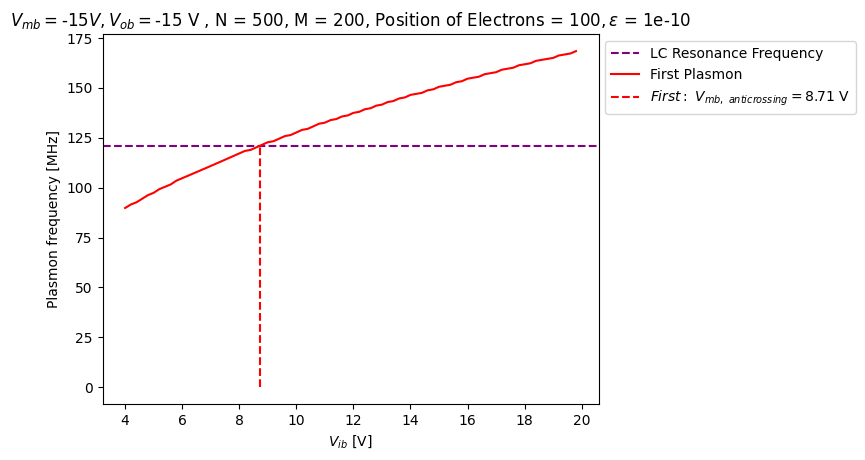

In [73]:
plt.xlabel('$V_{ib}$ [V]')
plt.ylabel('Plasmon frequency [MHz]')

LCResonanceFrequency = 120.945
plt.axhline(y = LCResonanceFrequency, linestyle = '--', color = 'purple', label = 'LC Resonance Frequency')

# needs to have the same number of elements as plasmon_labels
# define the colors for each plasmon
colors = ['r', 'g', 'b']

# Dictionnary to store splines for each plasmon
spline_plasmon = {}
spline_plot = {}

num_plasmons_to_plot = 3  

for i, name in zip(range(num_plasmons_to_plot), plasmon_labels):
    label = plasmon_labels[i]
    plt.plot(np.array(VibVector),
             plasmon_vectors[label],
             color=colors[i],
             label=f"{label} Plasmon")
    
    # convert to numpy arrays for interpolation
    VibVector = np.array(VibVector)
    plasmon_vectors[label] = np.array(plasmon_vectors[label])
    idx = np.argsort(VibVector)
    VibVector_sorted = VibVector[idx]
    plasmon_vectors_sorted = plasmon_vectors[label][idx]

    spline_plasmon[name] = itp.UnivariateSpline(
        np.array(VibVector_sorted),
        np.array(plasmon_vectors_sorted) - LCResonanceFrequency,
        s=20
    )
    print(i)

    # look for the voltages where the plasmon frequency crosses the LC resonance frequency
    if len(spline_plasmon[name].roots()>1):
        v_anti_crossing=np.round(spline_plasmon[name].roots()[0],2)
        plt.vlines(spline_plasmon[name].roots()[0], 0, LCResonanceFrequency, linestyle = '--', color=colors[i], label=rf"${name}:\ V_{{mb,\ anticrossing}} = {v_anti_crossing}\ \mathrm{{V}}$")

    # creates a spline for plotting
    spline_plot[name] = itp.UnivariateSpline(
        np.array(VibVector_sorted),
        np.array(plasmon_vectors_sorted),
        s=90
    )

plt.title('$V_{mb}=$'+str(Vmb)+'$ V , V_{ob}=$'+str(Vob)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Plot the colour map

<>:69: SyntaxWarning: invalid escape sequence '\G'
<>:86: SyntaxWarning: invalid escape sequence '\G'
<>:69: SyntaxWarning: invalid escape sequence '\G'
<>:86: SyntaxWarning: invalid escape sequence '\G'
C:\Users\riken\AppData\Local\Temp\ipykernel_54116\712863891.py:69: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Im($\Gamma$)')
C:\Users\riken\AppData\Local\Temp\ipykernel_54116\712863891.py:86: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Re($\Gamma$)')


kappa=0.3886341291731565
f_{LC}=129.58018005975157MHz
f_{R}=120.94592957478439MHz


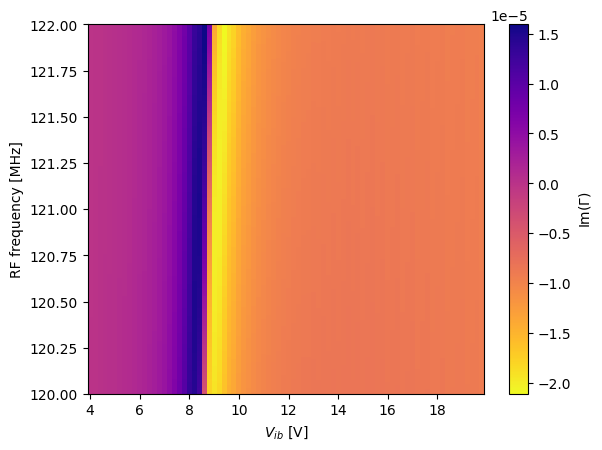

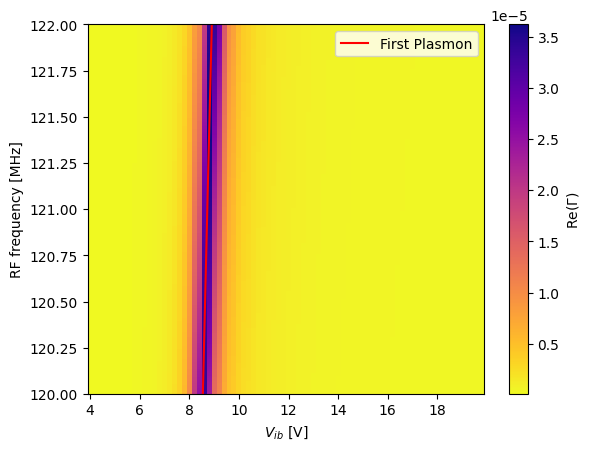

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


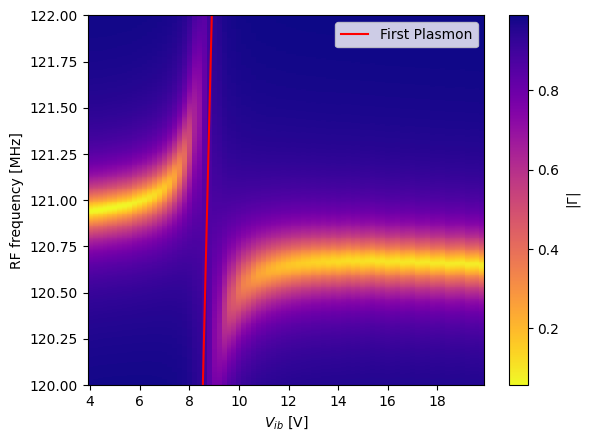

In [81]:
f_LC=omega_vector/(2*np.pi)

# creates an array to store the real and imaginary parts of the impedance
Matrix_Imag = np.zeros((len(DataStruct), len(DataStruct[0]['Impedance'])))

for i in range(0, len(DataStruct)):
    Matrix_Imag[i] = (np.imag(DataStruct[i]['Impedance']))

Matrix_Real = np.zeros((len(DataStruct), len(DataStruct[0]['Impedance'])))

for i in range(0, len(DataStruct)):
    Matrix_Real[i] = (np.real(DataStruct[i]['Impedance']))

Z0=50 

# values from the article: https://doi.org/10.48550/arXiv.2504.09890
Cc=0.315083*1e-12
L=708*1e-9
C=2.130737*1e-12
Res=321.98*1e3
omegaLC = 1/np.sqrt(L*C)
omegaR=np.sqrt(C/(C+Cc))*omegaLC
fr=omegaR/(2*np.pi)
angular_kappa=(1/Res + ((omegaR*Cc*Z0)**2)/Z0 )/(C+Cc)
print('kappa='+str((angular_kappa/(2*np.pi))*1e-6))





print('f_{LC}='+str(1e-6*omegaLC/(2*np.pi))+'MHz') 
print('f_{R}='+str(1e-6*fr)+'MHz') 

# see Sec V of the calculations for the derivations of the formulas
Q0=omegaLC*C*Res

OneOverZp=1j * np.matrix(Matrix_Imag).T/Vit_AC/9e11 + np.matrix(Matrix_Real).T/Vit_AC/9e11

phase=-1
ZL=Res/(1+phase*1j*Q0*(omega_vector/omegaLC-omegaLC/omega_vector))


OneOverZL = np.zeros((len(DataStruct), len(ZL)), dtype = "complex")
for i in range(0, len(DataStruct)):
    OneOverZL[i] = 1/ZL


Z_L_new = 1/(np.matrix(OneOverZL).transpose() + np.matrix(OneOverZp))
# if you zant to check the plot without the plasmon
# Z_L_new = 1/(np.matrix(OneOverZL).transpose() )

CouplingMatrix = np.zeros((len(DataStruct), len(omega_vector)), dtype = "complex")
for i in range(0, len(DataStruct)):
    CouplingMatrix[i] = 1/(phase*1j*omega_vector*Cc)

Z_l = np.matrix(CouplingMatrix).transpose()+ np.matrix(Z_L_new)


Gamma = (Z_l - Z0)/(Z_l + Z0)


#---------------- plot ------------------#


plasmon_labels = ["First"]
colors = ['r']

plt.pcolormesh(np.array(VibVector), omega_vector/(2*np.pi*1e6), (np.imag(OneOverZp)), shading="auto", cmap = 'plasma_r')
plt.colorbar(label='Im($\Gamma$)')
plt.xlabel('$V_{ib}$ [V]')
plt.ylim((120, 122))
plt.ylabel('RF frequency [MHz]')
plt.show()


plt.pcolormesh(np.array(VibVector), omega_vector/(2*np.pi*1e6), (np.real(OneOverZp)), shading="auto", cmap = 'plasma_r')



for color, name in zip(colors,plasmon_labels):
    plt.plot(np.array(VibVector), spline_plot[name](np.array(VibVector)), color = color, label = name+' Plasmon')

plt.xlabel('$V_{ib}$ [V]')
plt.ylabel('RF frequency [MHz]')
plt.ylim((120, 122))  
plt.colorbar(label='Re($\Gamma$)')
plt.legend()
plt.show()



Gamma=np.asarray(Gamma)
fig, ax = plt.subplots()
pcm=ax.pcolormesh(np.array(VibVector), omega_vector/(2*np.pi*1e6), np.abs(Gamma), shading="auto", cmap = 'plasma_r')
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label(r'$|\Gamma|$')
ax.set_xlabel('$V_{ib}$ [V]')
ax.set_ylabel('RF frequency [MHz]')

for color, name in zip(colors,plasmon_labels):
    ax.plot(np.array(VibVector), spline_plot[name](np.array(VibVector)), color = color, label = name+' Plasmon')

ax.set_ylim((120, 122))  

ax.legend()
fig.savefig("Vibsweep_m30V.eps", format='eps', dpi=300)



## Calculate the modes

8.71472187580559
8.800000000000004


<Figure size 800x500 with 0 Axes>

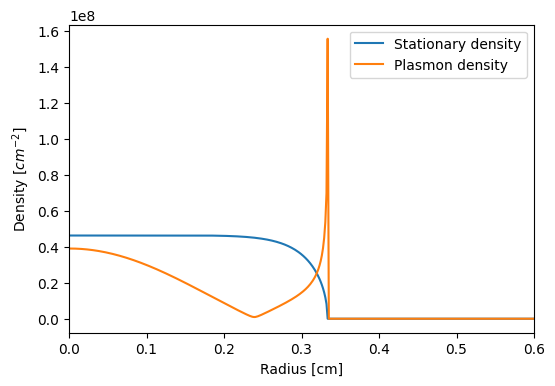

C:\Users\riken\AppData\Local\Temp\ipykernel_54116\819752305.py:110: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm2 = ax2.pcolormesh(X, Y, Z,


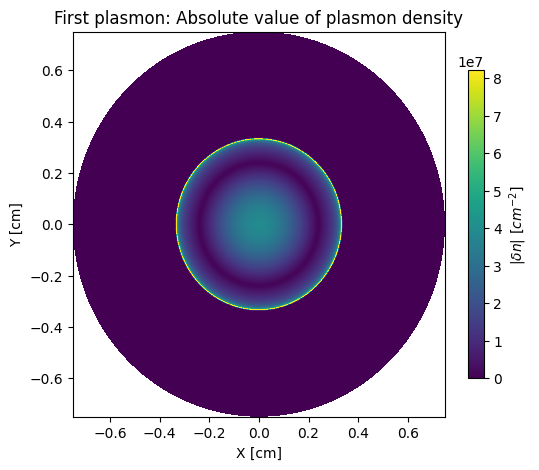

C:\Users\riken\AppData\Local\Temp\ipykernel_54116\819752305.py:124: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm3 = ax3.pcolormesh(X, Y, Z_imag,


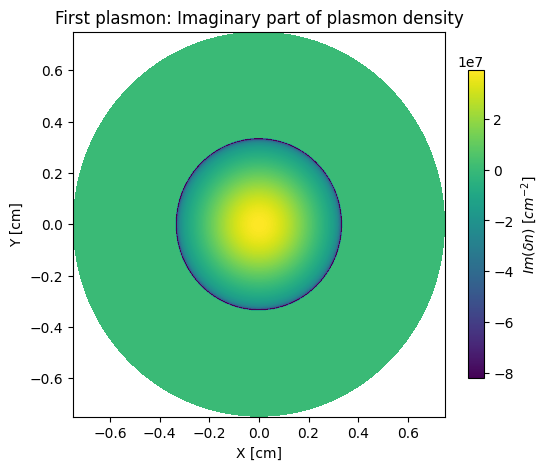

C:\Users\riken\AppData\Local\Temp\ipykernel_54116\819752305.py:140: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm4 = ax4.pcolormesh(X, Y, Z_real,


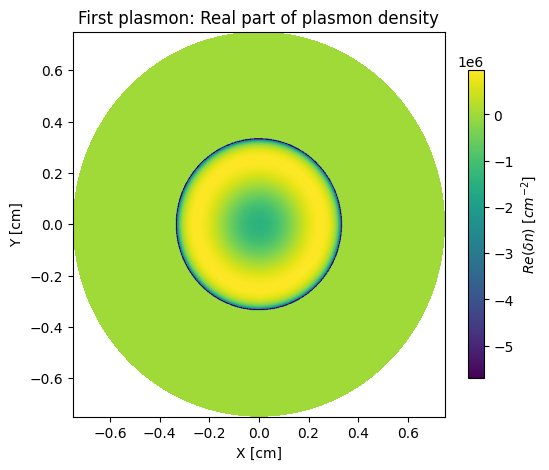

In [78]:
from scipy.ndimage import gaussian_filter
%matplotlib inline

# choose the plasmon number you want to plot
# the frequency of this plasmon needs to cross the LC resonance frequency
Plasmon_number='First'
plt.figure(figsize=(8, 5))

# choose the resonance voltage
voltage=spline_plasmon[Plasmon_number].roots()[0]
print(voltage)

fileIndex = np.argmin(np.abs(np.array(VibVector)-voltage))
print(VibVector[fileIndex])
plasmon_frequency=DataStruct[fileIndex][Plasmon_number + 'Plasmon']*2*np.pi*1e6
omega = plasmon_frequency


tau = 3.85363e-8
deltafunc = np.eye(N+1,N+1)
E = np.zeros((N, N), dtype = "complex")
D = np.zeros((N, N), dtype = "complex")
F = np.zeros((N, N), dtype = "complex")
H = np.zeros((N, N), dtype = "complex")
sigma = np.zeros(N, dtype = "complex")
b = np.zeros(N, dtype = "complex")
density_AC = np.zeros(N, dtype = "complex")



# ------- Find radius_of_electron_pool  -------- #
density=np.array(DataStruct[fileIndex]["density"])
# hr * K = radius_of_electron_pool
# with the notations of the calculations, K=m+1
K = np.amin((np.nonzero(density == 0))) 

np.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
np.copyto(D[0:K, 0:K], DStart[0:K, 0:K])

#  see Sec. V-B of the calculations for the derivations of those expressions
# -------- Calculate D ----------- #
D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]
rdash=np.array(rdash)


# -------- Calculate E ----------- #
# Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 
E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
for j in range(0, K):
    E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

# -------- Calculate sigma, the conductivity----------- #

sigma[0:K] = np.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

# -------- Calculate F  ----------- #
F=np.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

# -------- Calculate b----------- #
b[0] = rdash[0] * sigma[0] * Ertil[0]
b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]

    
# -------- Calculate H----------- #
H[0:K,0:K] = -1j * (omega * e/(2*np.pi))*D[0:K,0:K]+F[0:K,0:K]
    
#----------Calculate the densities ie the \delta n  ----------- #
density_AC[0:K] = np.dot((b[:K]),np.linalg.inv((H[:K,:K])))


# # ------------------ use conservation of charge --------------------- #
density_AC[K] -= np.sum(A[0:K] * (density_AC[0:K])/A[K])
# ------------------ out of the pool --------------------- #
density_AC[K+1:N] = 0


theta = np.linspace(0, 4 * np.pi, 10000)
R, Theta = np.meshgrid(rdash[0:N], theta)


X = R * np.cos(Theta)
Y = R * np.sin(Theta)


Z = np.tile(np.abs(density_AC[0:N]), (len(theta), 1))
Z_real= np.tile(np.real(density_AC[0:N]), (len(theta), 1))
Z_imag= np.tile(np.imag(density_AC[0:N]), (len(theta), 1))



Z = gaussian_filter(Z, sigma=1)
Z_real = gaussian_filter(Z_real, sigma=1)
Z_imag = gaussian_filter(Z_imag, sigma=1)   

# 2D plot of the densities 
fig1, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(rdash[0:N], density[0:N],      label='Stationary density')
ax1.plot(rdash[0:N], np.abs(density_AC[0:N]), label='Plasmon density')
ax1.set_xlim(0, 0.6)
ax1.set_xlabel('Radius [cm]')
ax1.set_ylabel('Density $[cm^{-2}]$')
ax1.legend()
plt.show()



# 3D plot of the absolute value of the plasmon density
fig2, ax2 = plt.subplots(figsize=(6,5))
pcm2 = ax2.pcolormesh(X, Y, Z,
                      shading='nearest',
                      cmap='viridis')
ax2.set_title(f'{Plasmon_number} plasmon: Absolute value of plasmon density')
ax2.set_xlabel('X [cm]')
ax2.set_ylabel('Y [cm]')
fig2.colorbar(pcm2,
               ax=ax2,
               shrink=0.8,
               label=r'$|\delta n|\ [cm^{-2}]$')
plt.show()

# 3D plot of the imaginary part of the plasmon density
fig3, ax3 = plt.subplots(figsize=(6,5))
pcm3 = ax3.pcolormesh(X, Y, Z_imag,
                      shading='nearest',
                      cmap='viridis')
ax3.set_title(f'{Plasmon_number} plasmon: Imaginary part of plasmon density')
ax3.set_xlabel('X [cm]')
ax3.set_ylabel('Y [cm]')
fig3.colorbar(pcm3,
               ax=ax3,
               shrink=0.8,
               label=r'$Im(\delta n)\ [cm^{-2}]$')
plt.show()



# 3D plot of the real part of the plasmon density
fig4, ax4 = plt.subplots(figsize=(6,5))
pcm4 = ax4.pcolormesh(X, Y, Z_real,
                      shading='nearest',
                      cmap='viridis')
ax4.set_title(f'{Plasmon_number} plasmon: Real part of plasmon density')
ax4.set_xlabel('X [cm]')
ax4.set_ylabel('Y [cm]')
fig4.colorbar(pcm4,
               ax=ax4,
               shrink=0.8,
               label=r'$Re(\delta n)\ [cm^{-2}]$')
plt.show()